# Prediction of Rental prices of  Apartments in and around KPHB

**OBJECTIVE** : Prediction of Apartment rental prices (posted by house owners) in KPHB.
    
**STEPS** : To achieve the above task, we are supposed to perform a series of sub tasks. Below are the sub tasks:
        
            1) Data Collection
            2) Data Cleansing
            3) Data Visualization
            4) Data Preprocessing
            5) Machine learning model ( Regression model)
            
We will go though each subtask in detail in below cells. Here we go :
 

# T1 : Data Collection
    
Data collection is the first and foremost thing before we do anything. Data can be available in any format such files, database tables,audios,videos etc.

However , in our case we dont have any prepared dataset to work with. Data related to our project is available on **Housing.com** website which is posted by house owners. Many more websites do have rental details but I found housing.com has more results set and hence i chose that.

In general, If data is present on website ,then we need to extract infromation either using **API calls** or **scraping**. Since **Housing.com** didnt provide any API to access information and hence we will develop a **scraper** which can grab the infromation from website which we are looking for.

Without wasting our time lets do some code
    
Before we code, make sure that below modules are installed in your environment. Im using CONDA environment and so most of the packages are pre installed. If you are working on some other environment which doesnt has these packages pre installed try below command in your command prompt line inorder to download them.
    
**pip install module name**


In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import html
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn import metrics

I have imported modules and now we will see why we need these modules. I will give a one line description about these packages:
    
**Selenium** : Used to automate web browsing operations such as opening,scrolling,click on links ,closing etc.. and extract the information stored in html tags using HTTP protocols.
    
**Time** : used to delay process in this project, but there is lot more scope so check documenation available for time module 
    
**Beautiful soup**: used to extract information from websites
    
**Pandas** : used to perform exploratory analysis
    
**Matplotlib** : to create visual plots based on data
    
**HTML** : used to parse html tags in this project but there is lot more scope so check documenation available for html module

**Sklearn** : used to build machine learning models
        
Coming to data collection part, we are using selenium to automate the opening ,scrolling down,extract page source (containing html tags) and closing page operations. Beautiful soup is to extract data from page source.

We are looking to scrape information such as price,no of bedrooms,address,house type(apartments or independent houses or villas),Area and other details for each house listed on website.

Here is **scraper** code :



In [2]:
chrome_options = Options()
chrome_options.add_argument("--headless")

driver=webdriver.Chrome(options=chrome_options)

driver.get("https://housing.com/rent/search-Eg5yr")

last_height = driver.execute_script("return document.body.scrollHeight")

i=1


while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(10)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height
    i=i+1

html=driver.page_source
driver.close()
print(f'No of scroll downs made by webdriver : {i}')


No of scroll downs made by webdriver : 92


In [3]:
page=bs(html,"html.parser")
elements=page.findAll("article",{"class":"css-8jw9t9"})

records_set=[]
for i in elements:
    price=i.find("div",{"data-q":"price"})
    details=i.find("a",{"class":"css-dk6esa"})
    address=i.find("a",{"data-q":"address"})
    features=i.findAll("span",{"class":"css-wze9ea"})
    if(len(features)>1): 
        records_set.append([price.text,details.text,address.text,features[0].text,features[1].text])
    else:
        records_set.append([price.text,details.text,address.text,None,None])

Above code performs the below tasks in sequential order :
    
1) Selecting the browser to open the website. Here you can select Firefox or chrome. (It automatically opens window)

2) Enter url **Housing.com** in chrome window (automated)

3) Scrolling down to the end of the page where no more loading happens. We usually see this in e commerce websites.

4) Now the page is loaded completely, we extract page source (containing html tags and data embed)

5) Close driver (now it automatically closes window if the above commands worked fine without error)

6) Parse the page source using beautiful soup with html parser.

7) Find the elements where the data resides in parsed page source.

8) loop through elemnts and extract the data in form of 2d lists.

# T2: Data Cleansing

This is the most important part of data analysis. We need to check for missing data or nulls, datatypes,duplicates etc.. to proceed to data analysis.

Now that we have list as result from above code. We will import data to dataframe (table like structure) and specify field names.

In [4]:
df=pd.DataFrame(records_set)
df.columns=["Price","Details","Address","features","Area"]
print(df.head())

    Price                  Details  \
0  15,700  2 BHK Independent House   
1   9,500          1 BHK Apartment   
2  14,000          1 BHK Apartment   
3  25,000          3 BHK Apartment   
4  19,000          1 BHK Apartment   

                                             Address         features  \
0              Jal Vayu Vihar, Kukatpally, Hyderabad  Fully Furnished   
1                  Tulasi Nagar, Madhapur, Hyderabad      Unfurnished   
2  Jubliee Annex, Chanda Naik Nagar, Madhapur, Hy...   Semi Furnished   
3             Vasantha Nagar, Hyder Nagar, Hyderabad   Semi Furnished   
4  Jubliee Annex, Chanda Naik Nagar, Madhapur, Hy...  Fully Furnished   

         Area  
0  1100 sq.ft  
1   600 sq.ft  
2   650 sq.ft  
3  1600 sq.ft  
4   800 sq.ft  


Now we will see for nulls in data throughout the dataframe. so we are using describe function to get counts

In [5]:
df.info()
df.drop(df[df.Details=='Studio Apartment'].index,axis=0,inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804 entries, 0 to 1803
Data columns (total 5 columns):
Price       1804 non-null object
Details     1804 non-null object
Address     1804 non-null object
features    1804 non-null object
Area        1804 non-null object
dtypes: object(5)
memory usage: 70.6+ KB


So it seems like the counts are equal for all columns so we dont have any missing values. Thats great !

Now lets proceed further casting datatypes to perform some numerical operations


In [6]:
df["Bedrooms"]=df["Details"].apply(lambda x:x.split(" ")[0])
df["House_type"]=df["Details"].apply(lambda x:x.split(" ")[2])
df["Area"]=df["Area"].apply(lambda x:float(x.split(" ")[0]))
df["Price"]=df["Price"].apply(lambda x:int("".join(x.split(","))))
df[["Address","features","House_type"]]=df[["Address","features","House_type"]].astype(str)
df=df[(df.Bedrooms!='2.5')&(df.Bedrooms!='5+')]
df['Bedrooms']=df.Bedrooms.astype(int)

There might be a chance of a person placing the same advertisement multiple times on website. Hence we are removing the duplicates.

In [7]:
df.drop_duplicates(keep='first',inplace=True)
df.count()

Price         1470
Details       1470
Address       1470
features      1470
Area          1470
Bedrooms      1470
House_type    1470
dtype: int64

Load data to csv file. Its always good practice to keep files as logs for further analysis. Howver we will work on existing data frames in further analysis.

In [8]:
df.to_csv("house_rentals_kphb.csv",header=True,index=False,mode='w')

In [9]:
df1=pd.read_csv("house_rentals_kphb.csv",header=0)
df1.drop(df1[(df1['House_type']!='Apartment')|(df1['Details']=='1 RK Apartment')].index,axis=0,inplace=True)
df1=df1.sort_values('Area',ascending=False)

# T3 : Data Visualization

This task is something which we cant ignore because this is the only way we can show our business clients about the data we worked on. Numbers are helpful but without plot, it doesnt make any sense. 

If we miss this out, there is a chance of losing some critical infromation which numbers didnt say. So its must and should for every analyst to work on.

Coming back to topic, there is correlation matrix but I want to visualize it to see how well they are correlated. For now we will see correlation between price and other variables.

In [10]:
df1.corr()

,Price,Area,Bedrooms
Price,1.000000,0.638265,0.581031
Area,0.638265,1.000000,0.718675
Bedrooms,0.581031,0.718675,1.000000


**Below are my observations**:(after checking correlation matrix)

1) It is clear that feature Area and Bedrooms has strong relationship. But it is pretty much expected that when number of Bedrooms increases Area does increase.

2) When it comes to relation with Price, all three features exhibits positive relationship. But the strenth of relationship is higher in Area feature. If you see clearly in above area vs price plot, outliers are present. Outliers will affect the correlation coeffecient. 

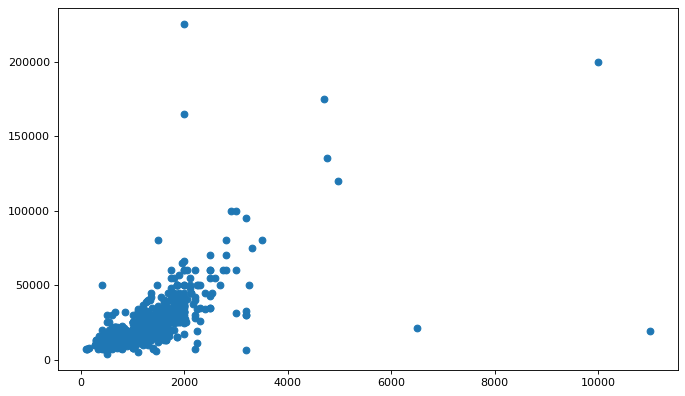

In [11]:
plt.figure(figsize=(10,6),dpi=80)
plt.scatter(df1['Area'],df1['Price'])

plt.show()

We plotted Price and Area information on **scatter** plot to see how data points are spread out. 

**Below are my observations** :

1) Seems like there is a linear relationship between these varibales. But we cannot conclude the kind of relationship, before we explore more. Practically speaking, relationship between **Area** and **Price** is linear most of the times. But we will observe that using Quantile-Quantile plot and see.

3) There are few data points, which are far away from densely populated points,  they are outliers. We will remove them using median based method. But we will surely analyze the outliers in next update.

## Removal of outliers

Outlier are the data points which will affect the relationship between variables and eventually it even affects prediction model too which will be discussed in later stage.

For now, we will focus on removing outliers. Since we are dealing with bi variate data, we created a another variable named **ind** which contains values calculated by dividing Price with Area.

Main idea for creating above variable is to combine both variables data in one which makes some sense. It is quite simple to remove outliers in univariate data and so i I've chosen this approach.

Now we have got a variable name **ind** with values, we will now proceed with removing outliers.

we have got many options to remove outliers, but i've chosen Quantile based method( median based) because it is simple and effective. You can check quantile based method on google for clear understanding.



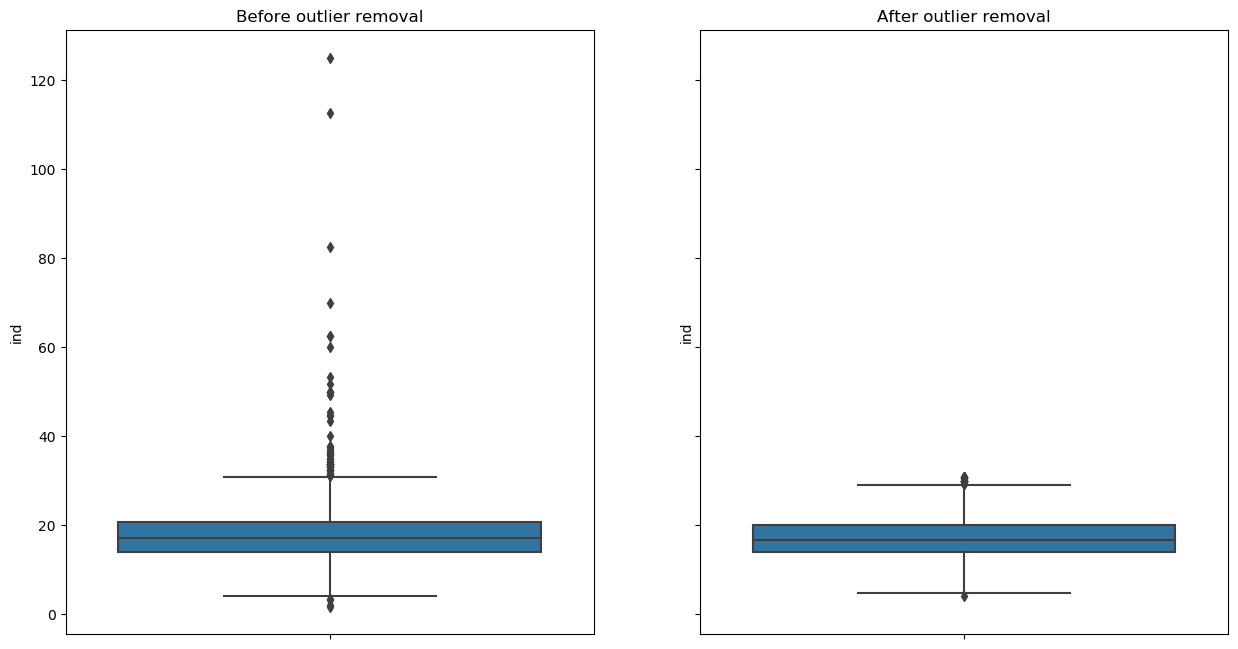

In [12]:
df1['ind']=df1['Price']/df1['Area']

fig,ax=plt.subplots(1,2,figsize=(15,8),dpi=100,sharey=True)

sn.boxplot(df1.ind,showfliers=True,orient='v',ax=ax[0])

ax[0].set_title('Before outlier removal')

ub=df1.ind.quantile(0.75)
lb=df1.ind.quantile(0.25)
ex=(ub-lb)*1.5

df2=df1.drop(df1[(df1.ind>=(ub+ex))|(df1.ind<=(lb-ex))].index,axis=0)

sn.boxplot(df2.ind,showfliers=True,orient='v',ax=ax[1])

ax[1].set_title('After outlier removal')

plt.show()



Median and other quantiles are not affected by presence of outliers whereas mean is highly sensitive and hence we used quantile based approach (median based ) for outlier removal. 

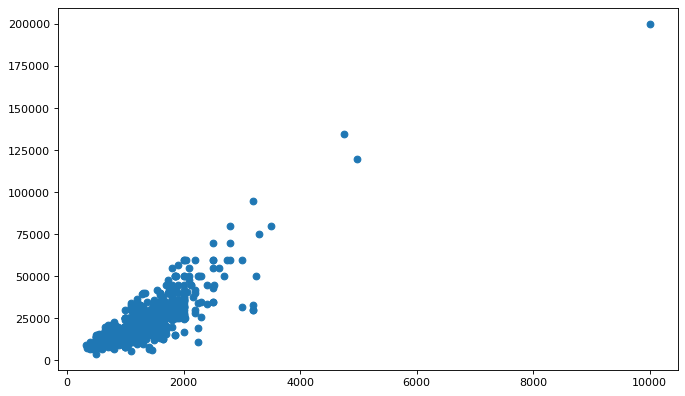

In [13]:
plt.figure(figsize=(10,6),dpi=80)
plt.scatter(df2['Area'],df2['Price'])

plt.show()

In [14]:
df2.corr()

,Price,Area,Bedrooms,ind
Price,1.000000,0.846003,0.695748,0.440715
Area,0.846003,1.000000,0.841287,-0.054355
Bedrooms,0.695748,0.841287,1.000000,-0.051929
ind,0.440715,-0.054355,-0.051929,1.000000


- After reomval of outliers we are able to attain a very good correlation coeffecient between Price( dependent variable) and other independent variables ( Area, Bedrooms).


- But if we use both the independent variables in model building, we might overfit the data. This may lead to more biased model. Although there is strong relation between dependent and independent variable. it is observed that there is collinearity present among independent variables. 



- Inorder to avoid over fit, it is always good to consider only one variable which is **Area**. The reason for choosing **Area** because it has much stronger correlation coefficient with **Price** than **Bedrooms**.

## Data preprocessing

Here we are going to convert categorical data into numeric data so that even categorical variables can also be used for Regression analysis. 

In [15]:
df2=df2.sort_values('Area',ascending=True).reset_index(drop=True)

dummies=pd.get_dummies(df2['features'],drop_first=True)

df2=pd.concat([df2,dummies],axis=1)

Among the categorical variables, there is one variable which actually affects the indepenent variables. It holds the information whether the apartment is unfurnished, semifurnished or fully furnished. Practically speaking, Retal prices surely variy with this infromation. And hence we will using this variable in regression model. 

## Regression model

In [16]:
dep=df2['Price'].values.reshape(-1,1)

ind=df2[['Area','Semi Furnished','Unfurnished']].values.reshape(-1,3)


model=LinearRegression()

model.fit(ind,dep)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
pred=model.predict(ind).reshape(1,-1)[0]

In [18]:
df2=pd.concat([df2,pd.Series(pred).sort_values(ascending=True)],axis=1).rename(columns={0:'predicted_price'})

In [19]:
df2['place']=df2['Address'].str.split(',').str[-2].str.strip(' ')

In [20]:
pred=model.predict(ind).flatten()

print(model.coef_.flatten(),model.intercept_)

print('r-squared value : {}'.format(round(metrics.r2_score(dep,pred),2)))

print('mean squared error : {}'.format(round(metrics.mean_squared_error(dep,pred),2)))

print('Root mean squared error : {}'.format(np.sqrt(round(metrics.mean_squared_error(dep,pred),2)))) 

[   18.25302641 -4413.7459745  -5666.75305859] [2694.48066698]
r-squared value : 0.73
mean squared error : 43722791.11
Root mean squared error : 6612.321159018215


**R squared** value indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. In our case it is 0.73 or 73%, which says variance in dependent variable is well explained by the regression line.

**Root mean squared error** explains how far the actual data points are located from regression line or predicted line. RMSE is key for OLS ( ordinary least squares) models because the objective of this model is to minimize the error caused by prediction line. And hence less error much better model. RMSE is highly sensitive to outliers and so as regression line. It is good check for outliers in data before building model. 